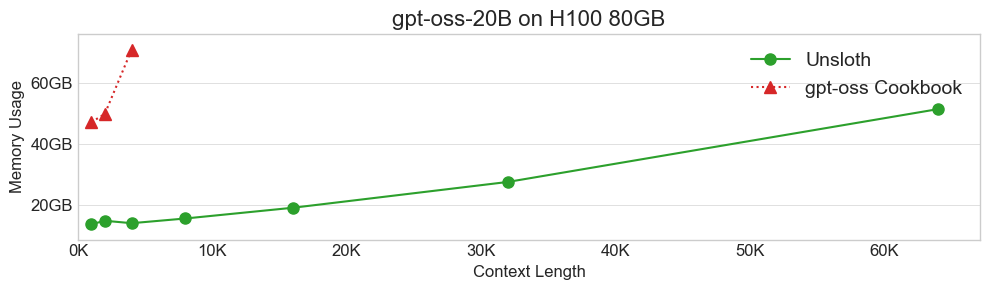

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import io
import pandas as pd
import re

# --- Data from both runs ---

# Data from your first message (Original Run)
data_string_1 = """
fr_gpt-oss_with_flex_65536	55376150528
fr_gpt-oss_with_flex_32768	29736370176
fr_gpt-oss_with_flex_16384	20645216256
fr_gpt-oss_with_flex_8192	16864051200
fr_gpt-oss_with_flex_4096	15207301120
fr_gpt-oss_with_flex_2048	16062939136
fr_gpt-oss_with_flex_1024	14827716608
"""

# The new OOM data you provided
data_string_oom = """
gpt_oss_cook_book_1024 = 47.3 GB
gpt_oss_cook_book_2048 = 50 GB
gpt_oss_cook_book_4096 = 71.1 GB
"""

# --- Processing functions for each data format ---

def process_wandb_data(data_string):
    """Parses the original 'run\tbytes' format."""
    df = pd.read_csv(io.StringIO(data_string.strip()), sep='\t', header=None, names=['run', 'memory_bytes'])
    df['context_length_k'] = df['run'].str.split('_').str[-1].astype(int) / 1024
    df['memory_gb'] = df['memory_bytes'] / (1024**3)
    return df.sort_values('context_length_k')

def process_oom_data(data_string):
    """Parses the new 'run = value GB' format."""
    lines = data_string.strip().split('\n')
    data = []
    for line in lines:
        name_part, value_part = line.split('=')
        # Extract the last number for context length
        context_length = int(re.findall(r'\d+$', name_part.strip())[0])
        # Extract the float value for memory
        memory = float(re.findall(r'[\d\.]+', value_part)[0])
        data.append({'context_length_k': context_length / 1024, 'memory_gb': memory})
    return pd.DataFrame(data).sort_values('context_length_k')

# Process both datasets using their respective functions
df1 = process_wandb_data(data_string_1)
df_oom = process_oom_data(data_string_oom)

# --- Create the plot ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 3))

# Plot data from the first run
ax.plot(df1['context_length_k'], df1['memory_gb'], marker='o', linestyle='-', color='#2ca02c', label='Unsloth', markersize=8)

# Plot data from the OOM run
ax.plot(df_oom['context_length_k'], df_oom['memory_gb'], marker='^', linestyle=':', color='#d62728', label='gpt-oss Cookbook', markersize=9)

# --- Style the graph for clear comparison ---
ax.set_title('gpt-oss-20B on H100 80GB', fontsize=16)
ax.set_xlabel('Context Length', fontsize=12)
ax.set_ylabel('Memory Usage', fontsize=12)

# Format axes
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{int(round(y))}GB'))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x)}K'))
ax.tick_params(axis='both', which='major', labelsize=12)

# Set axis limits to encompass all data points
min_gb = min(df1['memory_gb'].min(), df_oom['memory_gb'].min())
max_gb = max(df1['memory_gb'].max(), df_oom['memory_gb'].max())
ax.set_ylim(bottom=min_gb - 5, top=max_gb + 5)
ax.set_xlim(left=0)

# Add a legend to distinguish the lines
ax.legend(fontsize=14, frameon=False, loc='upper right', ncol=1)

# Make the grid lighter
ax.yaxis.grid(True, which='major', linestyle='-', linewidth=0.5, color='lightgray')
ax.xaxis.grid(False)

plt.tight_layout()
plt.savefig('gpt_oss_plot.pdf', format='pdf')
plt.show()

In [ ]:
# Save to pdf

<Figure size 640x480 with 0 Axes>